In [1]:
import numpy as np
from sklearn.utils import shuffle
from keras.utils import np_utils

# Same here
navs = ('Muy poco navegable', 'Poco navegable',
        'Navegable', 'Muy navegable')

x = np.load('nav_data.npy')
y = np.load('nav_data_labels.npy')
y = y-1

x_train, x_val, x_test = np.split(
    np.array(x), [int(len(x)*0.7), int(len(x)*0.85)])
y_train, y_val, y_test = np.split(
    np.array(y), [int(len(y)*0.7), int(len(y)*0.85)])


y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

n_clases = len(navs)
n_features = len(x[0])

print(np.unique(y, return_counts=True))
print(len(x))
print(len(y))
print(n_clases)
print(n_features)

2021-11-11 17:37:34.309303: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


(array([0, 1, 2, 3]), array([139, 128, 253, 336]))
856
856
4
17


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import backend

# We want to make sure we start from the start when training our model everytime we run it.
backend.clear_session()

# Define MLP model
model = Sequential()
model.add(Dense(256, input_dim=n_features, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(n_clases, activation='softmax'))

2021-11-11 17:37:36.779624: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-11 17:37:36.792164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-11 17:37:37.328827: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-11 17:37:37.328900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.215GHz coreCount: 46 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 357.69GiB/s
2021-11-11 17:37:37.329034: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-11 17:37:37.331565: I tensorflow/stre

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 23,268
Trainable params: 23,268
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [5]:
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# # Fit model
# class_weights = class_weight.compute_class_weight('balanced',
#                                                   np.unique(y),
#                                                   y)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=150, batch_size=2, callbacks=[es])
#dict(zip(np.unique(y), class_weights))),

2021-11-11 17:37:39.896296: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-11 17:37:39.897427: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2208005000 Hz


Epoch 1/150


2021-11-11 17:37:40.847532: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


300/300 [==============================] - 5s 13ms/step - loss: 2.4608 - accuracy: 0.3420 - val_loss: 1.4807 - val_accuracy: 0.3984
Epoch 2/150
300/300 [==============================] - 3s 10ms/step - loss: 1.9288 - accuracy: 0.4905 - val_loss: 1.7527 - val_accuracy: 0.3438
Epoch 3/150
300/300 [==============================] - 3s 10ms/step - loss: 1.7256 - accuracy: 0.4954 - val_loss: 1.5657 - val_accuracy: 0.4297
Epoch 4/150
300/300 [==============================] - 3s 10ms/step - loss: 1.3925 - accuracy: 0.5431 - val_loss: 1.4230 - val_accuracy: 0.4531
Epoch 5/150
300/300 [==============================] - 3s 10ms/step - loss: 1.1905 - accuracy: 0.5255 - val_loss: 1.5379 - val_accuracy: 0.4297
Epoch 6/150
300/300 [==============================] - 3s 10ms/step - loss: 1.2285 - accuracy: 0.5259 - val_loss: 1.2787 - val_accuracy: 0.3984
Epoch 7/150
300/300 [==============================] - 3s 10ms/step - loss: 1.0786 - accuracy: 0.4900 - val_loss: 1.2784 - val_accuracy: 0.4141
Epoc

In [6]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_acc)

5/5 [==============================] - 0s 6ms/step - loss: 2.7121 - accuracy: 0.3721
Loss on test set:  2.7121286392211914
Accuracy on test set:  0.3720930218696594


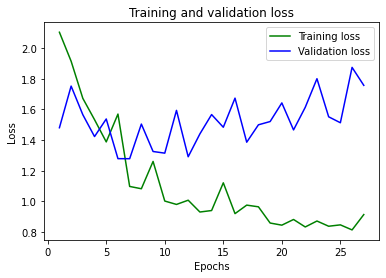

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
# bo is for blue dot.
plt.plot(epochs, loss, 'g', label='Training loss')
# b is for solid blue line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


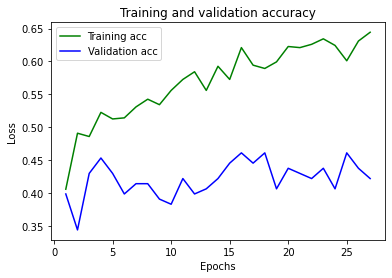

In [8]:
plt.clf()

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
